In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings, string
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('Preprocessed Fake Reviews Detection Dataset.csv')
df.head()

,Unnamed: 0,category,rating,label,text_
0,0,Home_and_Kitchen_5,5.0,CG,love well made sturdi comfort i love veri pretti
1,1,Home_and_Kitchen_5,5.0,CG,love great upgrad origin i 've mine coupl year
2,2,Home_and_Kitchen_5,5.0,CG,thi pillow save back i love look feel pillow
3,3,Home_and_Kitchen_5,1.0,CG,miss inform use great product price i
4,4,Home_and_Kitchen_5,5.0,CG,veri nice set good qualiti we set two month


In [3]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,love well made sturdi comfort i love veri pretti
1,Home_and_Kitchen_5,5.0,CG,love great upgrad origin i 've mine coupl year
2,Home_and_Kitchen_5,5.0,CG,thi pillow save back i love look feel pillow
3,Home_and_Kitchen_5,1.0,CG,miss inform use great product price i
4,Home_and_Kitchen_5,5.0,CG,veri nice set good qualiti we set two month


In [5]:
df.dropna(inplace=True)

In [6]:
df['length'] = df['text_'].apply(len)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40431 entries, 0 to 40431
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40431 non-null  object 
 1   rating    40431 non-null  float64
 2   label     40431 non-null  object 
 3   text_     40431 non-null  object 
 4   length    40431 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.9+ MB


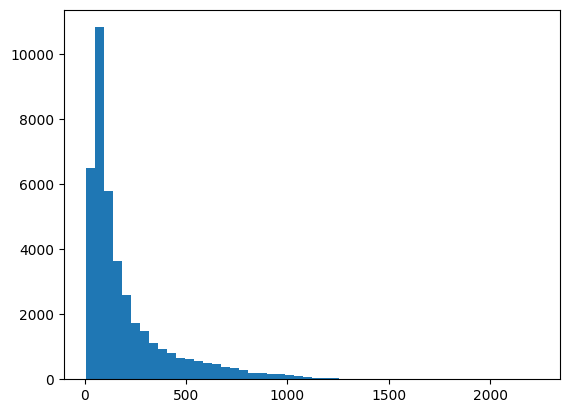

In [8]:
plt.hist(df['length'],bins=50)
plt.show()

In [9]:
df.groupby('label').describe()

rating                                                length  \
         count      mean       std  min  25%  50%  75%  max    count   
label                                                                  
CG     20215.0  4.259906  1.141092  1.0  4.0  5.0  5.0  5.0  20215.0   
OR     20216.0  4.253265  1.147652  1.0  4.0  5.0  5.0  5.0  20216.0   

                                                                 
             mean         std   min   25%    50%    75%     max  
label                                                            
CG     173.639030  173.955252  13.0  57.0   99.0  217.0  1300.0  
OR     237.892758  252.920635   8.0  74.0  134.0  296.0  2232.0

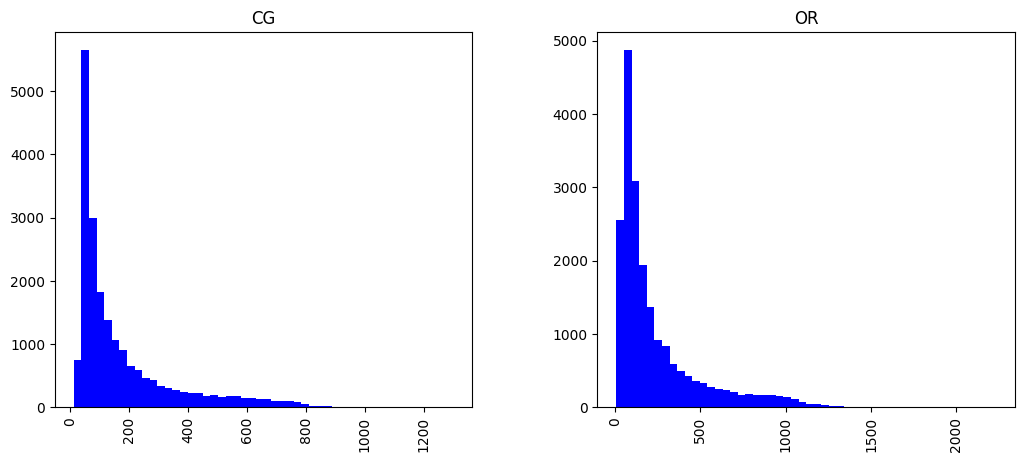

In [10]:
df.hist(column='length',by='label',bins=50,color='blue',figsize=(12,5))
plt.show()

Let's extract the largest review...

In [11]:
df[df['label']=='OR'][['text_','length']].sort_values(by='length',ascending=False).head().iloc[0].text_

"weak on current scienc after see twice i agre much posit five star review out respect read review i 'll repeat everyth i like present i found goofi over ear hairdo facial hair arrang daniel vitali describ `` wild food expert '' distract ugh ditto david wolf extrem goofi wild hairdo on hand jon gabriel describ `` author weight loss expert '' nice groom good present hi stori person transform fellow pound whew becom jock normal weight inspir christian northrup preserv rank one america 's cutest doctor a realli nice look woman present dr. mercola jason vale kri carr alejandro junger fine it disappoint jami oliv popular uk give babi cow growth fluid pas unscientif popular idea milk none present anyth zilch say work doctor t. colin campbel milk bodi bad it good see present take stand sugar they agre evil sugar refin carbohydr with respect dr. northrup `` it 's fat make fat 's sugar '' statement pas muster commun expert recogn evil sugar not mutual exclus recogn proven danger fat particularl

In [12]:
df.length.describe()

count    40431.000000
mean       205.766689
std        219.422084
min          8.000000
25%         64.000000
50%        116.000000
75%        253.000000
max       2232.000000
Name: length, dtype: float64

In [13]:
def text_process(review):
    nopunc = [char for char in review if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [14]:
bow_transformer = CountVectorizer(analyzer=text_process)
bow_transformer

CountVectorizer(analyzer=<function text_process at 0x00000150C817A3B0>)

In [15]:
bow_transformer.fit(df['text_'])
print("Total Vocabulary:",len(bow_transformer.vocabulary_))

Total Vocabulary: 34450


In [16]:
review4 = df['text_'][3]
review4

'miss inform use great product price i'

In [17]:
bow_msg4 = bow_transformer.transform([review4])
print(bow_msg4)
print(bow_msg4.shape)

  (0, 13598)	1
  (0, 15840)	1
  (0, 19848)	1
  (0, 23847)	1
  (0, 23977)	1
  (0, 32182)	1
(1, 34450)


There are 6 unique words in the 4th review.

In [18]:
feature_names = bow_transformer.get_feature_names_out()
print(feature_names[15841])
print(feature_names[23848])

informationdirect
pricecategori


In [19]:
bow_reviews = bow_transformer.transform(df['text_'])

In [20]:
print("Shape of Bag of Words Transformer for the entire reviews corpus:",bow_reviews.shape)
print("Amount of non zero values in the bag of words model:",bow_reviews.nnz)

Shape of Bag of Words Transformer for the entire reviews corpus: (40431, 34450)
Amount of non zero values in the bag of words model: 1013898


In [21]:
print("Sparsity:",np.round((bow_reviews.nnz/(bow_reviews.shape[0]*bow_reviews.shape[1]))*100,2))

Sparsity: 0.07


In [22]:
tfidf_transformer = TfidfTransformer().fit(bow_reviews)
tfidf_rev4 = tfidf_transformer.transform(bow_msg4)
print(bow_msg4)

  (0, 13598)	1
  (0, 15840)	1
  (0, 19848)	1
  (0, 23847)	1
  (0, 23977)	1
  (0, 32182)	1


In [23]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['mango']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['book']])

10.91422964906803
2.821684385176731


In [24]:
tfidf_reviews = tfidf_transformer.transform(bow_reviews)
print("Shape:",tfidf_reviews.shape)
print("No. of Dimensions:",tfidf_reviews.ndim)

Shape: (40431, 34450)
No. of Dimensions: 2


In [28]:
import joblib  # Import joblib for model persistence

In [29]:
# Save the vectorizer and transformer
joblib.dump(vectorizer, 'vectorizer.pkl')
joblib.dump(tfidf_transformer, 'tfidf_transformer.pkl')

['tfidf_transformer.pkl']

## Creating training and testing data

In [25]:
review_train, review_test, label_train, label_test = train_test_split(df['text_'],df['label'],test_size=0.35)

# Training and testing Multinomial Naive Bayes Algorithm on the preprocessed data

In [30]:
pipeline_nb = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

In [31]:
pipeline_nb.fit(review_train, label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x00000150C817A3B0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [32]:
nb_prediction = pipeline_nb.predict(review_test)
nb_prediction

array(['CG', 'CG', 'OR', ..., 'OR', 'OR', 'OR'], dtype='<U2')

In [33]:
print('Classification Report:',classification_report(label_test,nb_prediction))
print('Confusion Matrix:',confusion_matrix(label_test,nb_prediction))
print('Accuracy Score:',accuracy_score(label_test,nb_prediction))

Classification Report:               precision    recall  f1-score   support

          CG       0.83      0.89      0.86      7136
          OR       0.88      0.81      0.84      7015

    accuracy                           0.85     14151
   macro avg       0.85      0.85      0.85     14151
weighted avg       0.85      0.85      0.85     14151

Confusion Matrix: [[6359  777]
 [1333 5682]]
Accuracy Score: 0.8508939297576144


In [34]:
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,nb_prediction)*100,2)) + '%')

Model Prediction Accuracy: 85.09%


In [35]:
# Save the Naive Bayes pipeline
joblib.dump(pipeline_nb, 'naive_bayes_model.pkl')

['naive_bayes_model.pkl']

# Training and testing Random Forest Classifier on the preprocessed data

In [36]:
pipeline_rf = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',RandomForestClassifier())
])

In [37]:
pipeline_rf.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x00000150C817A3B0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

In [38]:
rfc_prediction = pipeline_rf.predict(review_test)
rfc_prediction

array(['CG', 'CG', 'OR', ..., 'OR', 'CG', 'OR'], dtype=object)

In [39]:
print('Classification Report:',classification_report(label_test,rfc_prediction))
print('Confusion Matrix:',confusion_matrix(label_test,rfc_prediction))
print('Accuracy Score:',accuracy_score(label_test,rfc_prediction))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,rfc_prediction)*100,2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.81      0.90      0.85      7136
          OR       0.88      0.78      0.83      7015

    accuracy                           0.84     14151
   macro avg       0.84      0.84      0.84     14151
weighted avg       0.84      0.84      0.84     14151

Confusion Matrix: [[6394  742]
 [1523 5492]]
Accuracy Score: 0.8399406402374391
Model Prediction Accuracy: 83.99%


In [40]:
# Save the Random Forest pipeline
joblib.dump(pipeline_rf, 'random_forest_model.pkl')

['random_forest_model.pkl']

# Training and testing Decision Tree Classifier on the preprocessed data

In [41]:
pipeline_dt = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',DecisionTreeClassifier())
])

In [42]:
pipeline_dt.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x00000150C817A3B0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', DecisionTreeClassifier())])

In [43]:
dt_prediction = pipeline_dt.predict(review_test)
dt_prediction

array(['OR', 'CG', 'OR', ..., 'OR', 'OR', 'CG'], dtype=object)

In [44]:
print('Classification Report:',classification_report(label_test,dt_prediction))
print('Confusion Matrix:',confusion_matrix(label_test,dt_prediction))
print('Accuracy Score:',accuracy_score(label_test,dt_prediction))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,dt_prediction)*100,2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.73      0.75      0.74      7136
          OR       0.74      0.72      0.73      7015

    accuracy                           0.74     14151
   macro avg       0.74      0.74      0.74     14151
weighted avg       0.74      0.74      0.74     14151

Confusion Matrix: [[5367 1769]
 [1966 5049]]
Accuracy Score: 0.736061055755777
Model Prediction Accuracy: 73.61%


In [45]:
# Save the Decision Tree pipeline
joblib.dump(pipeline_dt, 'decision_tree_model.pkl')

['decision_tree_model.pkl']

# Training and testing K Nearest Neighbors Classifier on the preprocessed data

In [46]:
pipeline_knn = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',KNeighborsClassifier(n_neighbors=2))
])

In [47]:
pipeline_knn.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x00000150C817A3B0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', KNeighborsClassifier(n_neighbors=2))])

In [48]:
knn_prediction = pipeline_knn.predict(review_test)
knn_prediction

array(['CG', 'CG', 'CG', ..., 'CG', 'CG', 'CG'], dtype=object)

In [49]:
print('Classification Report:',classification_report(label_test,knn_prediction))
print('Confusion Matrix:',confusion_matrix(label_test,knn_prediction))
print('Accuracy Score:',accuracy_score(label_test,knn_prediction))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,knn_prediction)*100,2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.55      0.97      0.70      7136
          OR       0.87      0.18      0.30      7015

    accuracy                           0.58     14151
   macro avg       0.71      0.58      0.50     14151
weighted avg       0.71      0.58      0.50     14151

Confusion Matrix: [[6942  194]
 [5750 1265]]
Accuracy Score: 0.5799590134972793
Model Prediction Accuracy: 58.0%


In [50]:
# Save the KNN pipeline
joblib.dump(pipeline_knn, 'knn_model.pkl')

['knn_model.pkl']

# Training and testing Support Vector Machine Classifier on the preprocessed data

In [51]:
pipeline_svc = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',SVC())
])

In [52]:
pipeline_svc.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x00000150C817A3B0>)),
                ('tfidf', TfidfTransformer()), ('classifier', SVC())])

In [53]:
svc_prediction = pipeline_svc.predict(review_test)
svc_prediction

array(['CG', 'CG', 'OR', ..., 'OR', 'OR', 'OR'], dtype=object)

In [54]:
print('Classification Report:',classification_report(label_test,svc_prediction))
print('Confusion Matrix:',confusion_matrix(label_test,svc_prediction))
print('Accuracy Score:',accuracy_score(label_test,svc_prediction))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,svc_prediction)*100,2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.90      0.87      0.88      7136
          OR       0.87      0.90      0.89      7015

    accuracy                           0.88     14151
   macro avg       0.88      0.88      0.88     14151
weighted avg       0.88      0.88      0.88     14151

Confusion Matrix: [[6214  922]
 [ 713 6302]]
Accuracy Score: 0.8844604621581513
Model Prediction Accuracy: 88.45%


In [55]:
# Save the SVM pipeline
joblib.dump(pipeline_svc, 'svm_model.pkl')

['svm_model.pkl']

# Training and testing Logistic Regression Classifier on the preprocessed data

In [56]:
pipeline_lr = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',LogisticRegression())
])

In [57]:
pipeline_lr.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x00000150C817A3B0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', LogisticRegression())])

In [58]:
lr_prediction = pipeline_lr.predict(review_test)
lr_prediction

array(['CG', 'CG', 'OR', ..., 'OR', 'OR', 'OR'], dtype=object)

In [59]:
print('Classification Report:',classification_report(label_test,lr_prediction))
print('Confusion Matrix:',confusion_matrix(label_test,lr_prediction))
print('Accuracy Score:',accuracy_score(label_test,lr_prediction))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,lr_prediction)*100,2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.87      0.86      0.87      7136
          OR       0.86      0.87      0.87      7015

    accuracy                           0.87     14151
   macro avg       0.87      0.87      0.87     14151
weighted avg       0.87      0.87      0.87     14151

Confusion Matrix: [[6132 1004]
 [ 886 6129]]
Accuracy Score: 0.866440534237863
Model Prediction Accuracy: 86.64%


In [60]:
# Save the Logistic Regression pipeline
joblib.dump(pipeline_lr, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']

# Summary of Accuracy

In [61]:
print('Performance of various ML models:')
print('\n')
print('Logistic Regression Prediction Accuracy:',str(np.round(accuracy_score(label_test,lr_prediction)*100,2)) + '%')
print('K Nearest Neighbors Prediction Accuracy:',str(np.round(accuracy_score(label_test,knn_prediction)*100,2)) + '%')
print('Decision Tree Classifier Prediction Accuracy:',str(np.round(accuracy_score(label_test,dt_prediction)*100,2)) + '%')
print('Random Forests Classifier Prediction Accuracy:',str(np.round(accuracy_score(label_test,rfc_prediction)*100,2)) + '%')
print('Support Vector Machines Prediction Accuracy:',str(np.round(accuracy_score(label_test,svc_prediction)*100,2)) + '%')
print('Multinomial Naive Bayes Prediction Accuracy:',str(np.round(accuracy_score(label_test,nb_prediction)*100,2)) + '%')

Performance of various ML models:


Logistic Regression Prediction Accuracy: 86.64%
K Nearest Neighbors Prediction Accuracy: 58.0%
Decision Tree Classifier Prediction Accuracy: 73.61%
Random Forests Classifier Prediction Accuracy: 83.99%
Support Vector Machines Prediction Accuracy: 88.45%
Multinomial Naive Bayes Prediction Accuracy: 85.09%


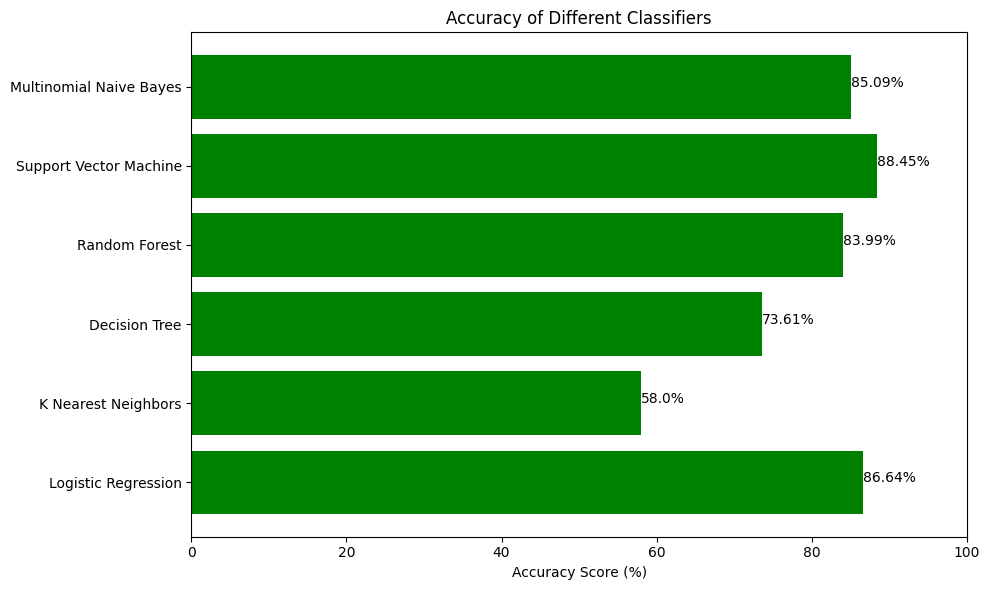

In [80]:
import matplotlib.pyplot as plt

# Classifier names
classifiers = ['Logistic Regression', 'K Nearest Neighbors', 'Decision Tree', 'Random Forest', 'Support Vector Machine', 'Multinomial Naive Bayes']

# Accuracy scores obtained from the model implementation
accuracy_scores = [86.64, 58.0, 73.61, 83.99, 88.45, 85.09]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.barh(classifiers, accuracy_scores, color='green')
plt.xlabel('Accuracy Score (%)')
plt.title('Accuracy of Different Classifiers')
plt.xlim(0, 100)

# Add accuracy score values on the bars
for index, value in enumerate(accuracy_scores):
    plt.text(value, index, str(value) + '%')

# Show plot
plt.tight_layout()
plt.show()

# Predict reviews using ensemble of classifiers

In [74]:
import pandas as pd
import joblib

# Load the out of sample reviews
out_of_sample_reviews = pd.read_csv('Out of Sample Reviews.csv')

# Load the trained models
logreg_model = joblib.load('logistic_regression_model.pkl')
svm_model = joblib.load('svm_model.pkl')
nb_model = joblib.load('naive_bayes_model.pkl')

# Define the function to predict the review using ensemble of classifiers
def predict_review(review, models):
    predictions = []
    for name, model in models.items():
        prediction = model.predict([review])[0]
        predictions.append(prediction)
    if predictions.count('CG') > predictions.count('OR'):
        return 'CG'
    elif predictions.count('CG') < predictions.count('OR'):
        return 'OR'
    else:
        return 'Undetermined'

# Predict each review
ensemble_predictions = []
for index, row in out_of_sample_reviews.iterrows():
    review = row['Review']
    prediction = predict_review(review, {'Logistic Regression': logreg_model, 
                                         'SVM': svm_model, 'Multinomial Naive Bayes': nb_model})
    ensemble_predictions.append(prediction)

# Add the predictions to the DataFrame
out_of_sample_reviews['Ensemble Prediction'] = ensemble_predictions

# Display the DataFrame with predictions
print(out_of_sample_reviews)


    Unnamed: 0                      category  rating label  \
0            1            Home_and_Kitchen_5       5    CG   
1            2            Home_and_Kitchen_5       5    OR   
2            3         Sports_and_Outdoors_5       5    CG   
3            4         Sports_and_Outdoors_5       5    OR   
4            5                 Electronics_5       5    CG   
5            6                 Electronics_5       5    OR   
6            7               Movies_and_TV_5       5    CG   
7            8               Movies_and_TV_5       4    OR   
8            9  Tools_and_Home_Improvement_5       4    CG   
9           10  Tools_and_Home_Improvement_5       5    OR   
10          11                Pet_Supplies_5       3    CG   
11          12                Pet_Supplies_5       3    OR   
12          13                Kindle_Store_5       5    CG   
13          14                Kindle_Store_5       4    OR   
14          15                       Books_5       5    CG   
15      

In [77]:
# Compute accuracy
correct_predictions = (out_of_sample_reviews['Ensemble Prediction'] == out_of_sample_reviews['label']).sum()
total_predictions = len(out_of_sample_reviews)
accuracy = (correct_predictions / total_predictions) * 100
print("Accuracy:", accuracy, "%")


Accuracy: 90.0 %
